### PSA: this set of solutions is INCOMPLETE. Look at exercise3_solutions.ipynb for Ulf's version of the solutions.

> **Note:** In most sessions you will be solving exercises posed in a Jupyter notebook that looks like this one. Because you are cloning a Github repository that only we can push to, you should **NEVER EDIT** any of the files you pull from Github. Instead, what you should do, is either make a new notebook and write your solutions in there, or **make a copy of this notebook and save it somewhere else** on your computer, not inside the `sds` folder that you cloned, so you can write your answers in there. If you edit the notebook you pulled from Github, those edits (possible your solutions to the exercises) may be overwritten and lost the next time you pull from Github. This is important, so don't hesitate to ask if it is unclear.

# Exercise Set 3: Crunching numbers (and wine)

*February 14, 2020*

In this Exercise Set 3 we will work with unsupervised machine learning, primarily dimensionality reduction and clustering, on the Wine and Digits datasets.

**Load data**

In [75]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits

# Get wine data
data_wine = load_wine()
X_wine = data_wine['data']
y_wine = data_wine['target']

# Get digits data
data_digits = load_digits()
X_digits = data_digits['data']
y_digits = data_digits['target']

<br>
<br>

## Dimensionality reduction

> **Ex. 3.1.1**: Implement PCA from scratch, and apply it to the wine dataset.
1. Visualize data along the first two principal components. Make sure to comment your
code to explain where each bit fits in the overall PCA algorithm.
2. Plot the explained variance ratio for all components. It can be computed by taking the
of a component and dividing it by the sum of all eigenvalues.
>
> *Hint: You can follow the steps outlined in the slides, or in Raschka 2017. If you follow
my example from the slides, note that there was an error at step 4, which is now fixed in an
updated version on Github.*

In [92]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler


class kPCA:
    def __init__(self, k  = None):
        self.ssc = StandardScaler()
        self.k = k 
        self.W = None 
        self.explained_variance = None 
        self.pc_cov_mat = None
    
        
    def fit(self, X):
        if self.k is None:
            self.k = X.shape[1]
            
        self.ssc.fit(X)
        X_std = self.ssc.transform(X)
        cov_mat = np.cov(X_std.T)
        
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        top_k_eigen_vecs = self._find_top_vecs(eig_vals, eig_vecs)
        
        self.W = np.hstack([
            w.reshape(-1,1) for w in top_k_eigen_vecs
        ])
        
        return self
            
    
    def _find_top_vecs(self, eigen_values, eigen_vectors):
        pairs = zip(abs(eigen_values), eigen_vectors.T)
        sortedpairs = sorted(pairs, key = lambda pair: pair[0], reverse = True)
        eigen_values, eigen_vectors = zip(*sortedpairs)
        return eigen_vectors[:self.k]
        
    
    def transform(self, X):
        X_std = self.ssc.transform(X)
        pc = np.dot(X_std, self.W)
        
        # Compute explained variance
        var = [np.var(pci) for pci in pc.T]
        total = sum(var)
        self.explained_variance = [i/total for i in var]
        
        return pc

In [93]:
kpca = kPCA()
kpca.fit(X_wine)
pc = kpca.transform(X_wine)

Text(0, 0.5, '$PC_2$')

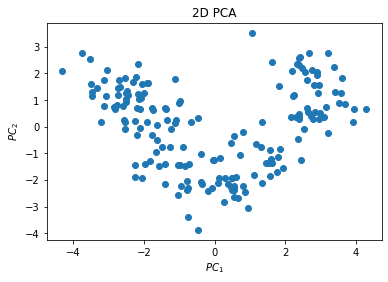

In [94]:
plt.scatter(pc[:,0], pc[:,1])
plt.title('2D PCA')
plt.xlabel('$PC_1$')
plt.ylabel('$PC_2$')

<BarContainer object of 13 artists>

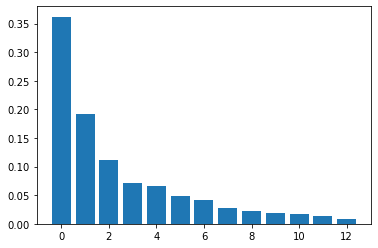

In [86]:
evar = kpca.explained_variance
plt.bar(range(len(evar)),evar)

Text(0.5, 1.0, 'PC cov.mat')

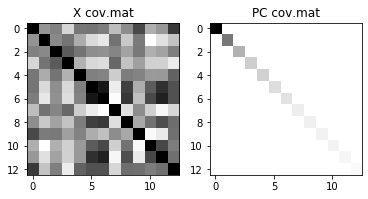

In [6]:
cov_mat_x = np.cov(StandardScaler().fit_transform(X_wine).T)
cov_mat_pc = np.cov(kpca.transform(X_wine).T)

fig,ax = plt.subplots(1,2)
ax[0].imshow(cov_mat_x, cmap = 'gray_r')
ax[1].imshow(cov_mat_pc, cmap = 'gray_r')
ax[0].set_title('X cov.mat')
ax[1].set_title('PC cov.mat')

> **Ex. 3.1.2**: Reproduce the figure from the slides that compares PCA, LDA, t-SNE and UMAP as applied to the digits dataset.
1. Do it for the digits dataset (same as in slides)
2. Do it also for the wine dataset. What problems do you observe if you don't standardize the wine dataset? Why is this not a problem with the digits data?
3. Comment on the differences you observe as well as the applicability (and necessity thereof) of different methods for different data.
>
> *Hint: You can use [this class](https://github.com/ulfaslak/ulf_pytools/blob/7f4f1eb7e2d721851c8dacb20904478b19090f2a/ulf.py#L451) for making coloring easier. It lets you create a function that takes a category as input and returns an associated color. Read the docstring for usage example.*

In [ ]:
# This question will be in assignment 1

## Clustering

> **Ex. 3.2.1**: Implement K-means. I have written parts of the core code and a template for the code below. You can use it if you get stuck. Preferably, write your code as a function that takes as input the data `X`, `K` and a maximum number of iterations, and outputs the kernels, the memberships and the number of iterations it took to converge. You must fit a K-Means solutions with 3 kernels on the wine dataset projected onto the first two principal components.
1. Make a plot like the one below, that also clearly shows the position of the fitted kernels.
2. Run your code 100 times and plot the distribution of iterations until convergence.
3. Since this is an unsupervised solution, the labels you have obtained are probably different from the ones given by the `y` vector. But we still want to assess its accuracy. You could deal with this by relabeling the solution, but it's easier to use the *adjusted mutual information* as a performance metric. Use `sklearn.metrics.adjusted_mutual_info_score` to report the performance of one clustering solution.

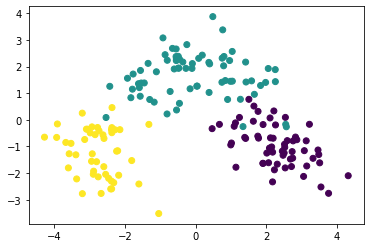

In [10]:
# fit the pca and get the two first components
X_wine_std = StandardScaler().fit_transform(X_wine)
X_wine_pca = PCA().fit_transform(X_wine_std)[:, :2]

# plot it for sanity
plt.scatter(X_wine_pca[:, 0], X_wine_pca[:, 1], c=y_wine)
plt.show()

In [95]:
class Centroid:
    ''' Centroid class for K-means centroids
    
    Parameters
    ----------
    name (str): name of centroid
    x0,x1,y0,y1 (float): bounding box of initial random placement.
    '''
    def __init__(self, name, x0=0, x1=1, y0=0, y1=1):
        self.name = name
        self.x = np.random.uniform(x0, x1)
        self.y = np.random.uniform(y0, y1)
        self.path = [(self.x, self.y)]
        
    def __repr__(self):
        return f'Centroid(x={self.x}, y={self.y})'
    
    def update(self, df, xname, yname):
        self.x = df[df['membership'] == self.name][xname].mean()
        self.y = df[df['membership'] == self.name][yname].mean()
        self.path.append((self.x, self.y))
        return self
    
    
    
def distance(x,y, centroid):
    ''' Euclidean distance from (x,y) 
    to a centroid.
    
    Parameters
    ----------
    x (float): x position of point
    y (float): y position of point
    centroid (Centroid): Centroid to measure 
        distance to.
        
        
    Returns
    -------
    float
    '''
    return np.sqrt((x - centroid.x)**2 + (y - centroid.y)**2)



def assign(df, centroids, xname = 0, yname = 1):
    ''' Assign points in df to clusters.
    
    Parameters
    ----------
    df: an array of (x,y) data.
    centroids: the centroids to cluster by.
    xname: name of x-column in data.
    yname: name of y-column in data.
    
    Returns
    -------
    pd.DataFrame
    '''
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
        
    for centroid in centroids:
        df[f'distance_to_{centroid.name}'] = distance(x = df[xname], y = df[yname], centroid=centroid)
        
    df['membership'] = df[[f'distance_to_{c.name}' for c in centroids]].idxmin(axis = 1).str.lstrip('distance_to_')
    
    return df

In [56]:
class KMeans:
    
    def __init__(self, k, max_iter = 50, plot = True):
        self.k = k
        self.max_iter = max_iter
        self.centroids = None 
        self.plot = plot
        
    def fit(self, df):
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df)

        self.centroids = [Centroid(str(k), 
                              min(df[0]),
                              max(df[0]),
                              min(df[1]), 
                              max(df[1])) 
                     for k in range(self.k)]

        
        old_members = None        
        for iter_ in range(self.max_iter):
            df = assign(df, self.centroids)
            if (old_members == df['membership']).all():
                break
            else:
                old_members = df['membership'].copy()

#            for c in self.centroids:
            self.centroids = [c.update(df, 0, 1) for c in self.centroids]

            # Plotting
            if self.plot:
                colors = {'0':'red', '1':'green', '2':'blue'}
                plt.scatter([c.path[0][0] for c in self.centroids], 
                            [c.path[0][1] for c in self.centroids], 
                            color = 'black', zorder = 10, label = 'initial mean point')
                sc = plt.scatter(df[0], df[1], 
                                 c = df['membership'].replace(colors), alpha = 0.2)
                for c in self.centroids:
                    plt.scatter([p[0] for p in c.path], 
                                [p[1] for p in c.path], 
                                color = colors[c.name], 
                                label = f'centroid {c.name}')
                    plt.plot([p[0] for p in c.path], 
                             [p[1] for p in c.path], 
                             color = colors[c.name])
                    plt.title(f'Step={iter_+1}')
                    plt.legend()
                plt.show()
                
        return iter_

    
    def predict(self, df):
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df)        
        return assign(df, self.centroids)['membership'].values

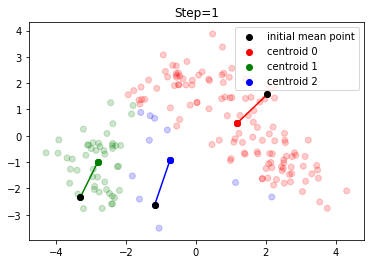

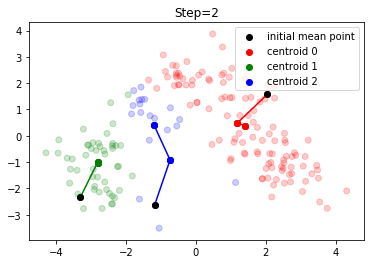

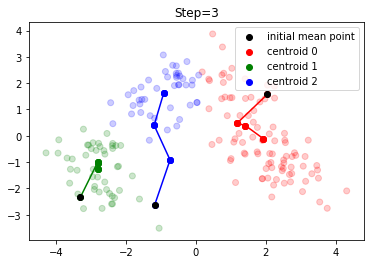

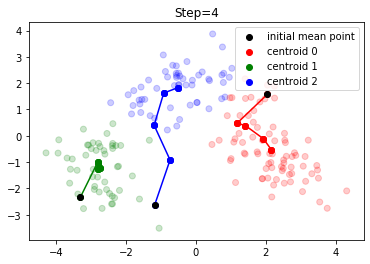

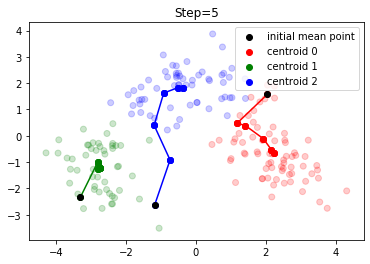

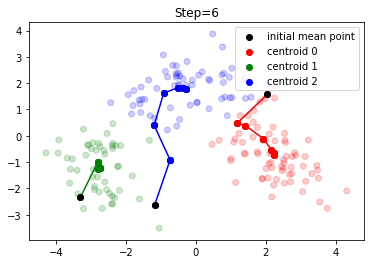

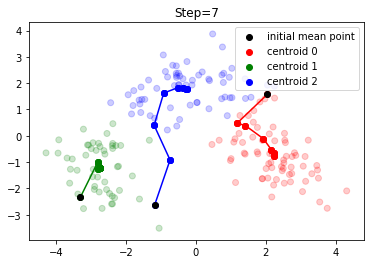

7

In [57]:
model = KMeans(k=3)
model.fit(X_wine_pca)

In [68]:
# Distribution of steps to convergence
model = KMeans(k = 3, plot = False)

n_steps = [model.fit(X_wine_pca) for _ in range(500)]

(array([ 55.,  93., 160.,  89.,  45.,  36.,  17.,   5.]),
 array([ 2.   ,  3.125,  4.25 ,  5.375,  6.5  ,  7.625,  8.75 ,  9.875,
        11.   ]),
 <a list of 8 Patch objects>)

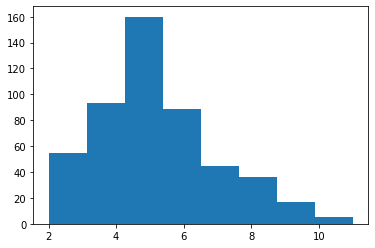

In [69]:
plt.hist(n_steps, bins = 8)

In [70]:
#AMIS
from sklearn.metrics import adjusted_mutual_info_score as amiscore

model = KMeans(k = 3, plot = False)
scores = []
for _ in range(500):
    model.fit(X_wine_pca)
    scores.append(
        amiscore(y_wine, model.predict(X_wine_pca))
    )

(array([ 22.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 475.]),
 array([0.46693867, 0.50856361, 0.55018854, 0.59181347, 0.6334384 ,
        0.67506333, 0.71668826, 0.75831319, 0.79993812, 0.84156306,
        0.88318799]),
 <a list of 10 Patch objects>)

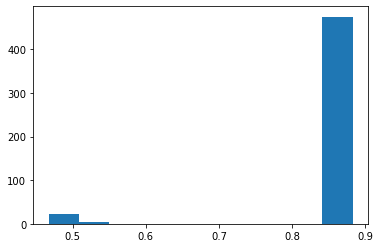

In [71]:
plt.hist(scores)

> **Ex. 3.2.2:** Fit a Gaussian Mixture Model, again to the PCA transformed wine data (same as previous exercise).
1. Report the adjusted mutual information score.
2. Make a plot similar to the one above, but where points are colored by their relative association.
>
> *Hint 2: Use [my `colormixer` function](https://github.com/ulfaslak/ulf_pytools/blob/7f4f1eb7e2d721851c8dacb20904478b19090f2a/ulf.py#L388)
to color the points. Predict memberships using the `predict_proba` method, and let row vectors be input
to the `weight` in the `colormixer` function. Example:*
>
>        colormixer(['#3E1F51', '#FEE824', '#1F908B'], weights=y_predicted[0])

> **Ex. 3.2.3:** Using the same approach as above to fit a GMM, evaluate the fit for a varying number of kernels (use `range(1, 11)`).
1. The "elbow method" compares cost function values for a varying number of kernels. It only decreases as `K`, decreases
and it is up to the human to interpret when the curve breaks, indicating what the best value of `K` is. Having fitted
a GMM object `gmm_model`, the cost function value (negative log likelihood) is obtained like `-sum(gmm_model.score_samples(X))`,
where `X` is the data you fitted the model to. Make an elbow plot and comment on it.
2. To make parameter choise easier, people often use AIC and BIC as corrections to the cost function values (they each add
different penalties to the cost function for having a large number of parameters in your model), that allows
one to take the minimum on the "elbow" curve (it's no longer an elbow plot, but you get the idea). In the same figure,
plot AIC and BIC within the range `range(1, 11)`. Comment on the result. Which one gives a better picture of what the right number of kernels is?
3. Repeat step 2, but with the full standardized wine dataset. Comment on the result. Does it still work?
4. Try with the digit data for `K` in `range(1, 21)`. Any comments?

> **Ex. 3.2.4:** If your solution looks anything like mine, you would conclude that parametric clustering has
problems in high-dimensional data with many clusters. So let's try a non-parametric approach, using DBSCAN.
* Fit DBSCAN (imported from sklearn) on the digit data in its original dimensions (`X_digits`),
* then visualize the result by plotting the t-SNE transformed datapoints, colored by their recovered cluster label.
* Try different values of `eps` with DBSCAN until you feel you have a satisfying result.
* Report the adjusted mutual information between the obtained labeling and the true labeling.
* Comment on your result.

> **Ex. 3.2.5:** Compare DBSCAN with agglomerative clustering. In a `for` loop over "distance threshold"
(corresponding to `eps` in DBSCAN):
* Obtain (1) DBSCAN, and agglomerative clustering solutions. For agglomerative clustering, obtain solutions for all
configurations of `linkage` (that it 'ward', 'average', 'complete', 'single').
* In total this gives you five different labelings of the datapoints in the `X_digits` dataset. For each, compute 
the adjusted mutual information (AMI) with the true labeling. Append these values to seperate arrays.
* In one figure, plot the AMI curve of each of the five methods. Label them properly and display a legend so one can compare
* Comment on the result. Which method performs the best on this dataset? How sensitive is each method to distance threshold?
>
> *Hint: A good range of distance thresholds is `range(6, 100)`.*